# XGBoost forex forecasting

## Importing libraries

In [1443]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

## Configuring settings

In [1444]:
warnings.filterwarnings('ignore')
sns.set_context('paper')

## Loading data

In [1445]:
df = pd.read_csv('data.csv')
df.head()

,Datetime,Close,High,Low,Open,Volume,price_change,price_change_abs,high_low_ratio,close_open_ratio,...,reddit_title_sentiment_mean,reddit_title_sentiment_std,reddit_title_sentiment_count,reddit_score_mean,reddit_score_sum,reddit_score_max,reddit_num_comments_mean,reddit_num_comments_sum,reddit_upvote_ratio_mean,fear_greed
0,2024-12-02 00:00:00,4.29639,4.30070,4.29376,4.29740,0,0.000000,0.000000,1.001616,0.999765,...,0.0,0.0,1.0,49.0,49.0,49.0,5.0,5.0,0.98,65.314286
1,2024-12-02 01:00:00,4.29662,4.30270,4.29588,4.29588,0,0.000053,0.000053,1.001588,1.000172,...,0.0,0.0,1.0,49.0,49.0,49.0,5.0,5.0,0.98,65.314286
2,2024-12-02 02:00:00,4.29928,4.29990,4.29673,4.29676,0,0.000619,0.000619,1.000738,1.000587,...,0.0,0.0,1.0,49.0,49.0,49.0,5.0,5.0,0.98,65.314286
3,2024-12-02 03:00:00,4.29724,4.29980,4.29679,4.29922,0,-0.000475,0.000475,1.000700,0.999539,...,0.0,0.0,1.0,49.0,49.0,49.0,5.0,5.0,0.98,65.314286
4,2024-12-02 04:00:00,4.29870,4.29978,4.29694,4.29723,0,0.000340,0.000340,1.000661,1.000342,...,0.0,0.0,1.0,49.0,49.0,49.0,5.0,5.0,0.98,65.314286


### Setting all column names to lowercase

In [1446]:
df.columns = [name.lower() for name in df.columns]

### Dropping columns that are zeroed

In [1447]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
close,3041.0,4.231019,0.044391,4.129470,4.187100,4.247910,4.268270,4.303400
high,3041.0,4.233653,0.044432,4.131400,4.189920,4.250400,4.270620,4.309260
low,3041.0,4.228350,0.044377,4.125200,4.184300,4.245500,4.265770,4.300300
open,3041.0,4.230995,0.044413,4.129370,4.187000,4.248020,4.268290,4.303400
volume,3041.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
price_change,3041.0,-0.000004,0.000765,-0.010166,-0.000351,0.000000,0.000335,0.005174
price_change_abs,3041.0,0.000513,0.000568,0.000000,0.000134,0.000340,0.000703,0.010166
high_low_ratio,3041.0,1.001254,0.000727,1.000000,1.000752,1.001124,1.001591,1.010563
close_open_ratio,3041.0,1.000006,0.000757,0.989721,0.999672,1.000000,1.000322,1.005186
sma_5d,3041.0,4.064171,0.821380,0.000000,4.183328,4.245943,4.265191,4.283391


In [1448]:
for name in df.columns:
    if len(df[name].unique()) == 1:
        print(f'Dropped column \"{name}\"')
        df.drop(name, axis=1, inplace=True)

Dropped column "volume"


### Excluding some of the columns

In [1449]:
excluded_columns = ['high', 'low', 'open', 'hour', 'day_of_week', 'is_weekend']
keep_columns = [column_name for column_name in df.columns if column_name not in excluded_columns]
df = df[keep_columns]

### Setting datetime as index

In [1450]:
df.datetime = pd.to_datetime(df.datetime)
df.set_index('datetime', inplace=True)

In [1451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3041 entries, 2024-12-02 00:00:00 to 2025-05-29 22:00:00
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   close                         3041 non-null   float64
 1   price_change                  3041 non-null   float64
 2   price_change_abs              3041 non-null   float64
 3   high_low_ratio                3041 non-null   float64
 4   close_open_ratio              3041 non-null   float64
 5   sma_5d                        3041 non-null   float64
 6   sma_10d                       3041 non-null   float64
 7   sma_25d                       3041 non-null   float64
 8   rsi_14d                       3041 non-null   float64
 9   bb_middle_20d                 3041 non-null   float64
 10  bb_upper_20d                  3041 non-null   float64
 11  bb_lower_20d                  3041 non-null   float64
 12  reddit_title_sentiment_mea

### Filling the weekend (no market data)

In [1452]:
df['day_of_week'] = df.index.day_of_week
df['hour'] = df.index.hour

In [1453]:
for day_of_week in df.day_of_week.unique():
    df_temp = df[df.day_of_week == day_of_week]
    print(f'{day_of_week}: {len(df_temp.hour.unique())}')

0: 24
1: 24
2: 24
3: 24
4: 23
6: 1


In [1454]:
full_range = pd.date_range(
    start = df.index.min(),
    end = df.index.max(),
    freq='H',
)

df = df.reindex(full_range)

In [1455]:
forward_fill_list = [column_name for column_name in df.columns if not column_name.startswith('reddit')]
forward_fill_list

['close',
 'price_change',
 'price_change_abs',
 'high_low_ratio',
 'close_open_ratio',
 'sma_5d',
 'sma_10d',
 'sma_25d',
 'rsi_14d',
 'bb_middle_20d',
 'bb_upper_20d',
 'bb_lower_20d',
 'fear_greed',
 'day_of_week',
 'hour']

In [1456]:
for column in forward_fill_list:
    df[column] = df[column].ffill()

df = df.fillna(0)

In [1457]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['day_of_month'] = df.index.day
df['is_weekend'] = [1 if day_of_week >= 5 else 0 for day_of_week in df.index.day_of_week]

## Feature engineering

### Adding cyclical features

In [1458]:
def create_time_features(df: pd.DataFrame, list_of_column_names: list[str]) -> None:
    for name in list_of_column_names:
        df[f'{name}_sin'] = np.sin(2 * np.pi * (df[name] - np.min(df[name])) / (np.max(df[name]) + 1))
        df[f'{name}_cos'] = np.cos(2 * np.pi * (df[name] - np.min(df[name])) / (np.max(df[name]) + 1))


In [1459]:
create_time_features(df, ['hour', 'day_of_week', 'day_of_month'])

In [1460]:
df[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']]

,day_of_week,day_of_week_sin,day_of_week_cos
2024-12-02 00:00:00,0,0.000000,1.000000
2024-12-02 01:00:00,0,0.000000,1.000000
2024-12-02 02:00:00,0,0.000000,1.000000
2024-12-02 03:00:00,0,0.000000,1.000000
2024-12-02 04:00:00,0,0.000000,1.000000
...,...,...,...
2025-05-29 18:00:00,3,0.433884,-0.900969
2025-05-29 19:00:00,3,0.433884,-0.900969
2025-05-29 20:00:00,3,0.433884,-0.900969
2025-05-29 21:00:00,3,0.433884,-0.900969


### Adding lags

In [1461]:
column_names_without_lags = [column_name for column_name in df.columns]

df.columns

Index(['close', 'price_change', 'price_change_abs', 'high_low_ratio',
       'close_open_ratio', 'sma_5d', 'sma_10d', 'sma_25d', 'rsi_14d',
       'bb_middle_20d', 'bb_upper_20d', 'bb_lower_20d',
       'reddit_title_sentiment_mean', 'reddit_title_sentiment_std',
       'reddit_title_sentiment_count', 'reddit_score_mean', 'reddit_score_sum',
       'reddit_score_max', 'reddit_num_comments_mean',
       'reddit_num_comments_sum', 'reddit_upvote_ratio_mean', 'fear_greed',
       'day_of_week', 'hour', 'day_of_month', 'is_weekend', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos'],
      dtype='object')

In [1462]:
time_column_names = [column_name for column_name in df.columns if 'hour' in column_name or 'day' in column_name or 'is_weekend' in column_name] 
time_column_names

['day_of_week',
 'hour',
 'day_of_month',
 'is_weekend',
 'hour_sin',
 'hour_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_month_sin',
 'day_of_month_cos']

In [1463]:
def add_lags(df: pd.DataFrame, lags: list[int], to_columns: list[str]) -> None:
    for column in to_columns:
        for lag in lags:
            df[f'{column}_{str(lag)}'] = df[column].shift(lag)

In [1464]:
lags = [1, 4, 12, 24, 48, 168, 336]
add_lags(df, lags, df.columns)
df

,close,price_change,price_change_abs,high_low_ratio,close_open_ratio,sma_5d,sma_10d,sma_25d,rsi_14d,bb_middle_20d,...,day_of_month_sin_48,day_of_month_sin_168,day_of_month_sin_336,day_of_month_cos_1,day_of_month_cos_4,day_of_month_cos_12,day_of_month_cos_24,day_of_month_cos_48,day_of_month_cos_168,day_of_month_cos_336
2024-12-02 00:00:00,4.29639,0.000000,0.000000,1.001616,0.999765,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02 01:00:00,4.29662,0.000053,0.000053,1.001588,1.000172,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.980785,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02 02:00:00,4.29928,0.000619,0.000619,1.000738,1.000587,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.980785,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02 03:00:00,4.29724,-0.000475,0.000475,1.000700,0.999539,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.980785,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-02 04:00:00,4.29870,0.000340,0.000340,1.000661,1.000342,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.980785,0.980785,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-29 18:00:00,4.24080,-0.000028,0.000028,1.000424,0.999953,4.244695,4.247185,4.255356,50.648052,4.251223,...,-0.92388,-0.83147,0.382683,0.707107,0.707107,0.707107,0.55557,0.382683,-0.55557,-0.92388
2025-05-29 19:00:00,4.23978,-0.000241,0.000241,1.000354,0.999877,4.244597,4.247152,4.255311,50.525868,4.251134,...,-0.92388,-0.83147,0.382683,0.707107,0.707107,0.707107,0.55557,0.382683,-0.55557,-0.92388
2025-05-29 20:00:00,4.24059,0.000191,0.000191,1.001180,1.000083,4.244512,4.247117,4.255267,50.637176,4.251053,...,-0.92388,-0.83147,0.382683,0.707107,0.707107,0.707107,0.55557,0.382683,-0.55557,-0.92388
2025-05-29 21:00:00,4.23620,-0.001035,0.001035,1.000779,0.999222,4.244432,4.247065,4.255210,50.314340,4.250960,...,-0.92388,-0.83147,0.382683,0.707107,0.707107,0.707107,0.55557,0.382683,-0.55557,-0.92388


## Exploring the data

### Plotting the feature correlation matrix

In [1465]:
correlation_with_close = df.corr().close.abs().sort_values(ascending=False)
correlation_with_close

close                   1.000000
close_1                 0.998053
close_4                 0.992495
close_12                0.978204
close_24                0.963498
                          ...   
day_of_week_sin         0.001691
hour_cos_4              0.001646
reddit_score_mean_48    0.001545
day_of_week_sin_1       0.000507
price_change_48         0.000344
Name: close, Length: 256, dtype: float64

## Splitting the data

In [1466]:
target_column = 'close'

feature_columns = [column for column in df.columns if column != target_column and column not in column_names_without_lags] + time_column_names
feature_columns

['close_1',
 'close_4',
 'close_12',
 'close_24',
 'close_48',
 'close_168',
 'close_336',
 'price_change_1',
 'price_change_4',
 'price_change_12',
 'price_change_24',
 'price_change_48',
 'price_change_168',
 'price_change_336',
 'price_change_abs_1',
 'price_change_abs_4',
 'price_change_abs_12',
 'price_change_abs_24',
 'price_change_abs_48',
 'price_change_abs_168',
 'price_change_abs_336',
 'high_low_ratio_1',
 'high_low_ratio_4',
 'high_low_ratio_12',
 'high_low_ratio_24',
 'high_low_ratio_48',
 'high_low_ratio_168',
 'high_low_ratio_336',
 'close_open_ratio_1',
 'close_open_ratio_4',
 'close_open_ratio_12',
 'close_open_ratio_24',
 'close_open_ratio_48',
 'close_open_ratio_168',
 'close_open_ratio_336',
 'sma_5d_1',
 'sma_5d_4',
 'sma_5d_12',
 'sma_5d_24',
 'sma_5d_48',
 'sma_5d_168',
 'sma_5d_336',
 'sma_10d_1',
 'sma_10d_4',
 'sma_10d_12',
 'sma_10d_24',
 'sma_10d_48',
 'sma_10d_168',
 'sma_10d_336',
 'sma_25d_1',
 'sma_25d_4',
 'sma_25d_12',
 'sma_25d_24',
 'sma_25d_48',
 's

In [1467]:
df.dropna(inplace=True)

In [1468]:
X = df[feature_columns]
y = df[target_column]

In [1469]:
split_index = len(df) - 24 * 7 * 2

In [1470]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

## Training the model

In [1471]:
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
)

In [1472]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

## Predicting

In [1473]:
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

## Plotting the prediction

In [1474]:
y_pred_df = pd.DataFrame(y_pred, columns=['close'], index=y_test.index)
y_pred_df.set_index(y_test.index, inplace=True)

Text(0.5, 1.0, 'Predykcja ceny EUR/PLN, wykorzystując dane tylko sprzed 1 godziny i wcześniej')

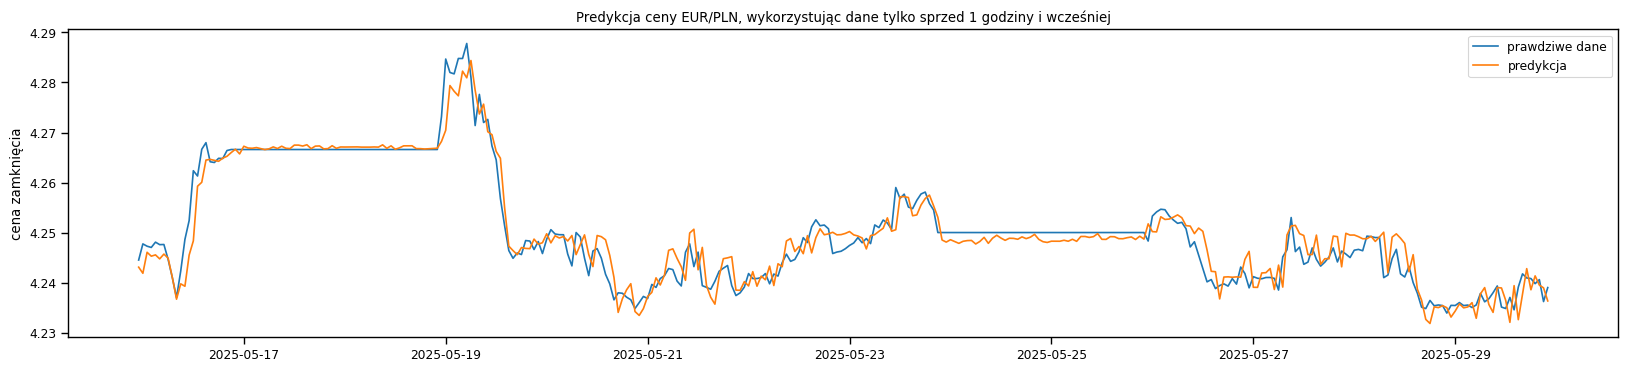

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(y_test, label='prawdziwe dane')
sns.lineplot(y_pred_df.close, label='predykcja')

ax.set_ylabel('cena zamknięcia')
ax.set_title('Predykcja ceny EUR/PLN, wykorzystując dane tylko sprzed 4 godzin i wcześniej')

In [1476]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

In [1477]:
print('Scores:')
print(mse)
print(rmse)
print(mae)
print(r2)
print(mape)

Scores:
9.121377314749075e-06
0.0030201618027432034
0.0021616263048989484
0.9257741161578883
0.05086857242993262


In [1478]:
for feature_name, feature_importance_score in sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1], reverse=True):
    print(f'{feature_name}: {feature_importance_score}')

close_1: 0.8931636214256287
close_4: 0.024687744677066803
day_of_month_sin_12: 0.004929973278194666
sma_25d_336: 0.0027684024535119534
sma_5d_336: 0.002306652255356312
fear_greed_168: 0.002175369765609503
bb_upper_20d_168: 0.0020666192285716534
close_12: 0.0015762461116537452
bb_upper_20d_12: 0.0014152241637930274
bb_lower_20d_168: 0.0013960220385342836
bb_middle_20d_48: 0.0012825268786400557
day_of_month_48: 0.0011877623619511724
bb_upper_20d_4: 0.001153679913841188
bb_middle_20d_168: 0.0009249328286387026
day_of_month_cos_4: 0.0009138626046478748
fear_greed_24: 0.0008663967018947005
day_of_month_12: 0.0008535886299796402
reddit_score_sum_168: 0.0008317799074575305
day_of_month_sin_168: 0.0007901160279288888
reddit_title_sentiment_mean_336: 0.0007580159581266344
sma_5d_168: 0.0007477471954189241
sma_25d_168: 0.0007405299111269414
price_change_4: 0.0006844856543466449
rsi_14d_1: 0.000653337046969682
bb_lower_20d_336: 0.0006367972819134593
bb_upper_20d_1: 0.0006274066399782896
close_336